In [1]:
from scripts.readers import read_images, read_image, save_TIFF
# from preprocess.test_filters import give_snr_2d, show_test_filter_sizes_2d
# from segment.thresh import threshold_image, hysteresis_thresh
# from segment.kmeans_clust import perform_kmeans_clustering_3d, extract_clusters_3d
# from segment.extract_pores import extract_pores_3d, segment_pores_watershed_3d, segment_pores_lbl_3d
# from segment.process_segments import merge_regions, filter_regions_by_size, get_neighbors
# from segment.distance_thickness import thickness_map_3d, compute_distance_from_centroid, compute_distance_from_centroid_zconstrain
# from pores.pore_network import analyze_pore_network_connectivity
# from plots.plots_3d import montage_pad
# from plots.colormaps_lec import goldenCM, randomCM

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cc3d
import seaborn as sns
import porespy as ps
import importlib as il
import os

from matplotlib.patches import Rectangle
from scipy.ndimage.filters import median_filter, gaussian_filter, uniform_filter
from scipy.ndimage import distance_transform_edt
from skimage.io import imread # read in images
from skimage.measure import regionprops, regionprops_table
from skimage.segmentation import mark_boundaries, watershed
from skimage.filters import try_all_threshold, threshold_isodata, threshold_otsu, sobel
from skimage.morphology import dilation, opening, ball, label, skeletonize_3d
from skimage.transform import rescale
from sklearn.metrics import roc_curve, auc
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from collections import OrderedDict
from importlib.metadata import version

[23:42:42] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=247337;file:///cluster/home/spruthi/miniconda3/envs/qbi2024/lib/python3.9/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=299166;file:///cluster/home/spruthi/miniconda3/envs/qbi2024/lib/python3.9/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

In [2]:
preprocess_test_filters = il.import_module("preprocess.test_filters")
preprocess_anisotropy = il.import_module("preprocess.anisotropy")

segment_thresh = il.import_module("segment.thresh")
segment_kmeans_clust = il.import_module("segment.kmeans_clust")
segment_extract_pores = il.import_module("segment.extract_pores")
segment_process_segments = il.import_module("segment.process_segments")
segment_distance_thickness = il.import_module("segment.distance_thickness")

pores_pore_network = il.import_module("pores.pore_network")
pores_pore_regionprops = il.import_module("pores.pore_regionprops")

plots_plots_3d = il.import_module("plots.plots_3d")
plots_colormaps_lec = il.import_module("plots.colormaps_lec")

In [3]:
preprocess_test_filters = il.reload(preprocess_test_filters)
preprocess_anisotropy = il.reload(preprocess_anisotropy)

segment_thresh = il.reload(segment_thresh)
segment_kmeans_clust = il.reload(segment_kmeans_clust)
segment_extract_pores = il.reload(segment_extract_pores)
segment_process_segments = il.reload(segment_process_segments)
segment_distance_thickness = il.reload(segment_distance_thickness)

pores_pore_network = il.reload(pores_pore_network)
pores_pore_regionprops = il.reload(pores_pore_regionprops)

plots_plots_3d = il.reload(plots_plots_3d)
plots_colormaps_lec = il.reload(plots_colormaps_lec)

In [4]:
# Load images
start_idx = 180
end_idx = 829
bread_type = 'V1a'
save_slice_num = str(int(end_idx-start_idx+1))
output_path = '/cluster/scratch/spruthi/qbi2024_project/'+bread_type+'_save_'+save_slice_num
if os.path.exists(output_path):
    print('Starting')
else:
    print('Target path created, check '+output_path)
    os.makedirs(output_path, exist_ok=True)
    print('Starting')

Target path created, check /cluster/scratch/spruthi/qbi2024_project/V1a_save_650
Starting


In [5]:
#img = read_images('/cluster/scratch/spruthi/qbi2024_project/Ru1a/Ru1a_0{0:04}.tif', 750, 1005)
img = read_images('/cluster/scratch/spruthi/qbi2024_project/'+bread_type+'/'+bread_type+'_0{0:04}.tif', start_idx, end_idx)
print(img.shape)

  0%|          | 0/650 [00:00<?, ?it/s]

(650, 1517, 1517)


In [6]:
# Crop image if required
img = img[:,150:1350,150:1350]

Text(0.5, 1.0, 'Slice Histogram')

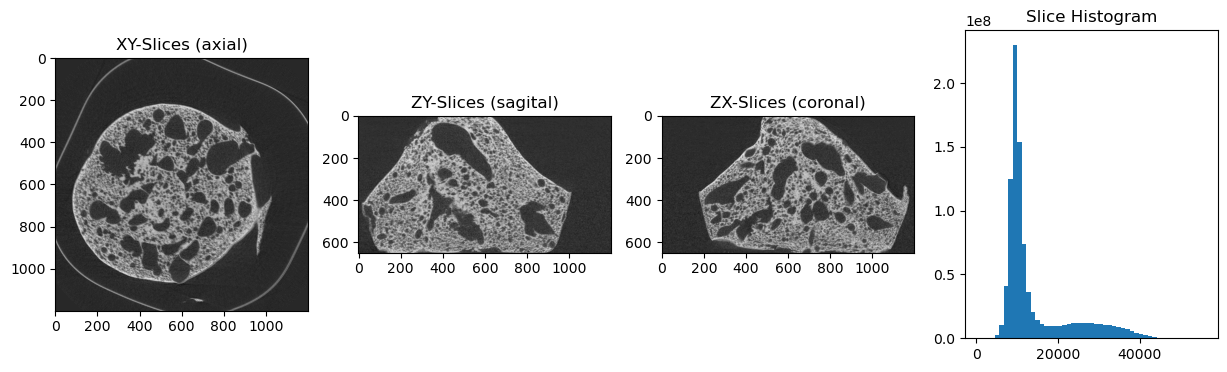

In [7]:
# Show middle slices from all angles and slice histogram
fig, ax = plt.subplots(1,4, figsize = (15, 4))
ax[0].imshow(img[img.shape[0]//2], cmap = 'gray')
ax[0].set_title('XY-Slices (axial)')
ax[1].imshow(img[:,img.shape[1]//2], cmap = 'gray')
ax[1].set_title('ZY-Slices (sagital)')
ax[2].imshow(img[:,:,img.shape[2]//2], cmap = 'gray')
ax[2].set_title('ZX-Slices (coronal)')
_ = ax[3].hist(img.ravel(), bins=51)
ax[3].set_title('Slice Histogram')

In [8]:
# Defining constants
img_sample = 300
downsampling_factor = 1
anis_rescaling = False

(Text(0.5, 0, 'Image value'), Text(0, 0.5, 'Number of pixels'))

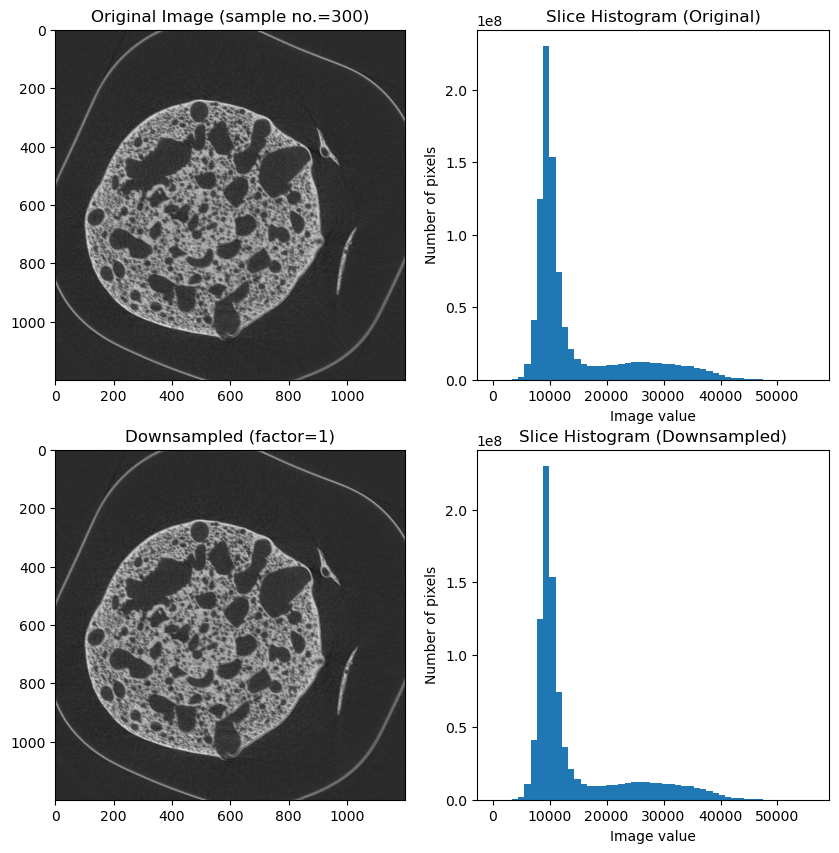

In [9]:
# Show original and downsampled image
if downsampling_factor>1:
    downsample_img = img[:,::downsampling_factor,::downsampling_factor]
else:
    downsample_img = img

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0,0].imshow(img[img_sample], cmap = 'gray')
ax[0,0].set_title(f'Original Image (sample no.={img_sample})')
_ = ax[0,1].hist(img.ravel(), bins=51)
ax[0,1].set_title('Slice Histogram (Original)')
ax[0,1].set_xlabel('Image value'), ax[0,1].set_ylabel('Number of pixels')
ax[1,0].imshow(downsample_img[img_sample], cmap = 'gray')
ax[1,0].set_title(f'Downsampled (factor={downsampling_factor})')
_ = ax[1,1].hist(downsample_img.ravel(), bins=51)
ax[1,1].set_title('Slice Histogram (Downsampled)')
ax[1,1].set_xlabel('Image value'), ax[1,1].set_ylabel('Number of pixels')
#ax[1,1].axvline(thresh, color='r')

In [10]:
# Anisotropy inference and rescaling
fft_based = False
if anis_rescaling:
    if fft_based:
        infer_anisotropy_fft_3d = getattr(preprocess_anisotropy,"infer_anisotropy_fft_3d")
        scaling_factors = infer_anisotropy_fft_3d(downsample_img)
    else:
        infer_anisotropy_structure_tensors_3d = getattr(preprocess_anisotropy,"infer_anisotropy_structure_tensors_3d")
        scaling_factors = infer_anisotropy_structure_tensors_3d(downsample_img)
    
    rescaled_ds_img = rescale(downsample_img, scale=scaling_factors, mode='reflect', anti_aliasing=True)

SNR for Original Image is 6.73315954208374
SNR for Downsampled Image is 1.967850685119629


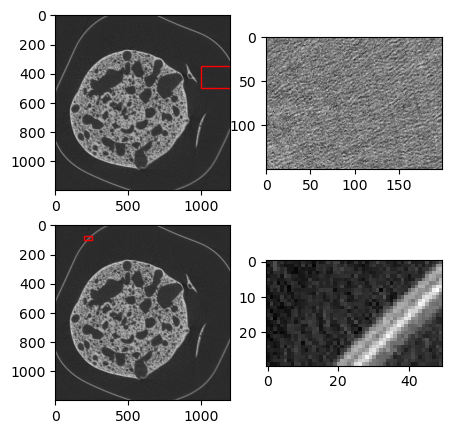

In [11]:
# Check SNR
give_snr_2d = getattr(preprocess_test_filters, "give_snr_2d")

# Defining bounding boxes - NOTE: Check dimensions
a1 = np.array([[1000,1200],[250,400]])
#a2 = np.array([[200,250],[70,100]])
a2 = a1 # For now
fig, ax = plt.subplots(2,2,figsize=(5,5))

snrA1, subA1 = give_snr_2d(img[img_sample], a1) # compute the snr
print("SNR for Original Image is {}".format(snrA1))
ax[0,0].imshow(img[img_sample], cmap='gray')
ax[0,0].add_patch( Rectangle((a1[0,0], a1[1,0]),
                        a1[0,1]-a1[0,0], a1[1,1]-a1[1,0],
                        fc ='none', 
                        ec ='r',
                        lw = 1) )

# extract a sub image
ax[0,1].imshow(subA1, cmap='gray');

snrA2, subA2 = give_snr_2d(downsample_img[img_sample], a2) # compute the snr
print("SNR for Downsampled Image is {}".format(snrA2))
ax[1,0].imshow(downsample_img[img_sample], cmap='gray')
ax[1,0].add_patch( Rectangle((a2[0,0], a2[1,0]),
                        a2[0,1]-a2[0,0], a2[1,1]-a2[1,0],
                        fc ='none', 
                        ec ='r',
                        lw = 1) )
# extract a sub image
ax[1,1].imshow(subA2, cmap='gray');

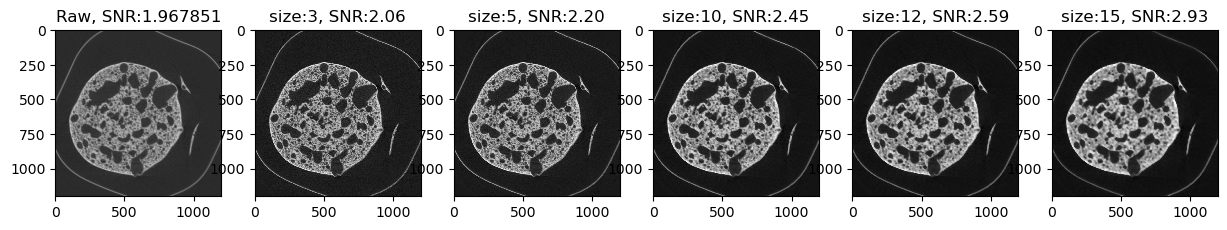

In [12]:
# Test filter sizes and types (default = median_filter)
show_test_filter_sizes_2d = getattr(preprocess_test_filters,"show_test_filter_sizes_2d")

N=[3,5,10,12,15];
show_test_filter_sizes_2d(downsample_img[img_sample], N, a2)

In [13]:
# Defining more constants
filtersize = 5
thresh = 22500
thresh_low = 17500

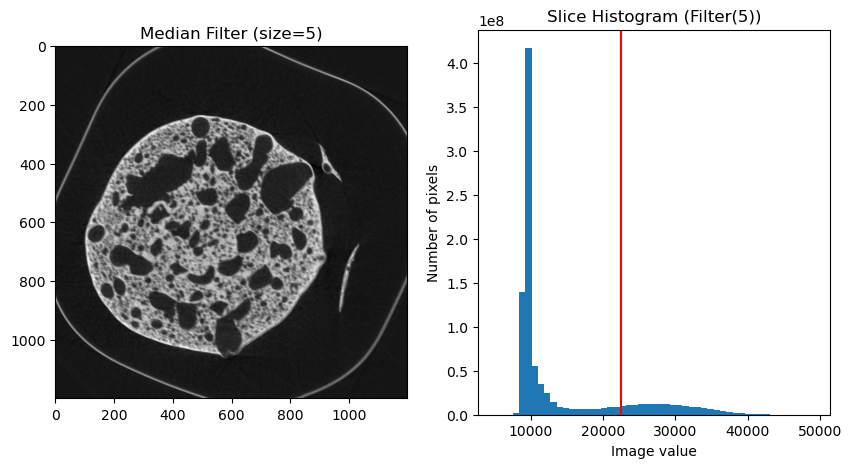

In [14]:
# Applying filter based on above tests and previous heuristics
medfilter3_ds_img = median_filter(downsample_img,filtersize)
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(medfilter3_ds_img[img_sample], cmap = 'gray')
ax[0].set_title(f'Median Filter (size={filtersize})')
_ = ax[1].hist(medfilter3_ds_img.ravel(), bins=51)
ax[1].set_title(f'Slice Histogram (Filter({filtersize}))')
ax[1].set_xlabel('Image value'), ax[1].set_ylabel('Number of pixels')
ax[1].axvline(thresh, color='r')

In [15]:
del snrA1, snrA2, subA1, subA2

Text(0.5, 1.0, 'Thresh Low Filtered Image')

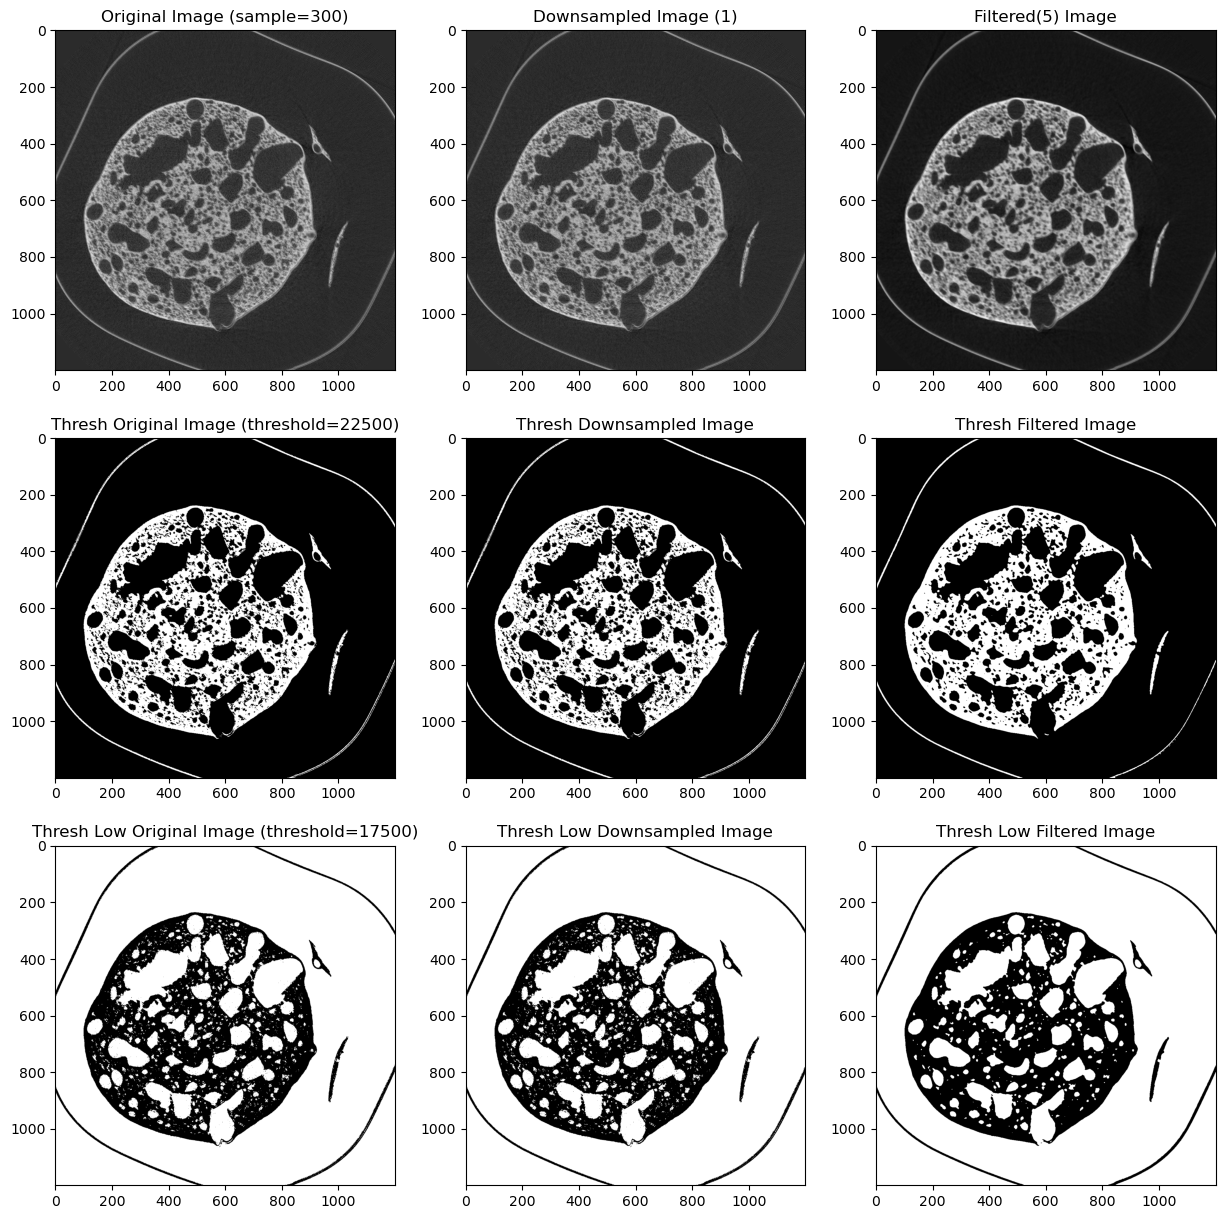

In [16]:
# Test heuristic threshold
threshold_image = getattr(segment_thresh,"threshold_image")

thresh_img = threshold_image(img, thresh)
thresh_ds_img = threshold_image(downsample_img, thresh)
thresh_filt3ds_img = threshold_image(medfilter3_ds_img, thresh)

threshlow_img = threshold_image(img, thresh_low, thresh_high_or_low='low')
threshlow_ds_img = threshold_image(downsample_img, thresh_low, thresh_high_or_low='low')
threshlow_filt3ds_img = threshold_image(medfilter3_ds_img, thresh_low, thresh_high_or_low='low')

# Visualize
fig, ax = plt.subplots(3,3, figsize = (15,15))

ax[0,0].imshow(img[img_sample], cmap = 'gray')
ax[0,0].set_title(f'Original Image (sample={img_sample})')
ax[0,1].imshow(downsample_img[img_sample], cmap = 'gray')
ax[0,1].set_title(f'Downsampled Image ({downsampling_factor})')
ax[0,2].imshow(medfilter3_ds_img[img_sample], cmap = 'gray')
ax[0,2].set_title(f'Filtered({filtersize}) Image')

ax[1,0].imshow(thresh_img[img_sample], cmap = 'gray')
ax[1,0].set_title(f'Thresh Original Image (threshold={thresh})')
ax[1,1].imshow(thresh_ds_img[img_sample], cmap = 'gray')
ax[1,1].set_title(f'Thresh Downsampled Image')
ax[1,2].imshow(thresh_filt3ds_img[img_sample], cmap = 'gray')
ax[1,2].set_title(f'Thresh Filtered Image')

ax[2,0].imshow(threshlow_img[img_sample], cmap = 'gray')
ax[2,0].set_title(f'Thresh Low Original Image (threshold={thresh_low})')
ax[2,1].imshow(threshlow_ds_img[img_sample], cmap = 'gray')
ax[2,1].set_title(f'Thresh Low Downsampled Image')
ax[2,2].imshow(threshlow_filt3ds_img[img_sample], cmap = 'gray')
ax[2,2].set_title(f'Thresh Low Filtered Image')

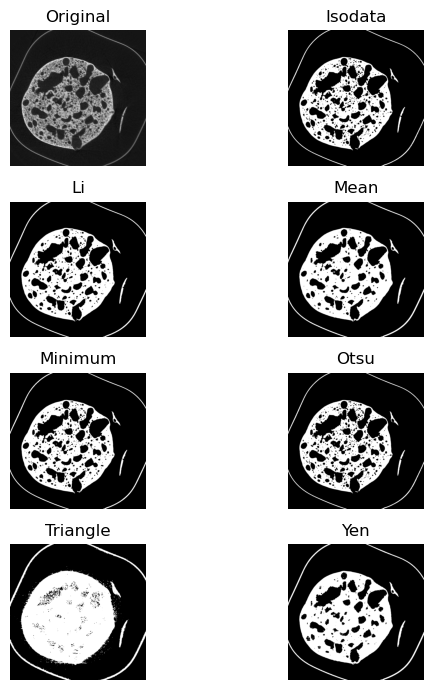

In [17]:
# Trying all thresholds
fig, ax = try_all_threshold(medfilter3_ds_img[img_sample], figsize=(7,7), verbose=False);

[18500.0, 20500.0]
Halfway there


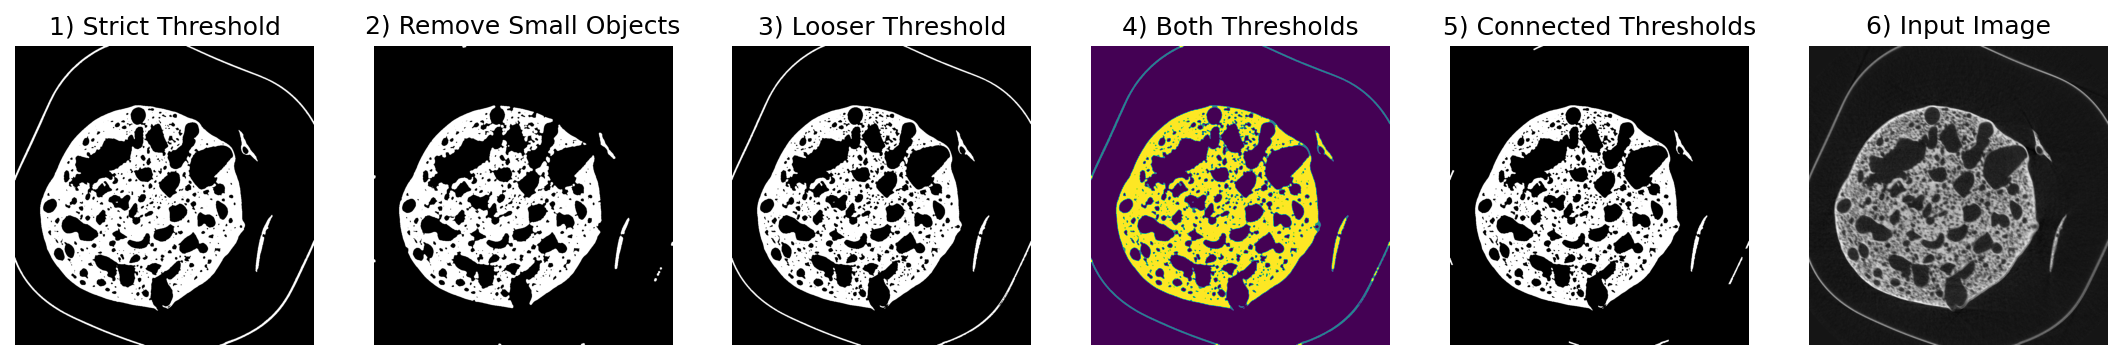

In [18]:
# Hysteresis workflow
hysteresis_thresh = getattr(segment_thresh,"hysteresis_thresh")

connthresh_medfilter3_ds_img = hysteresis_thresh(medfilter3_ds_img, img_sample, infer=True)

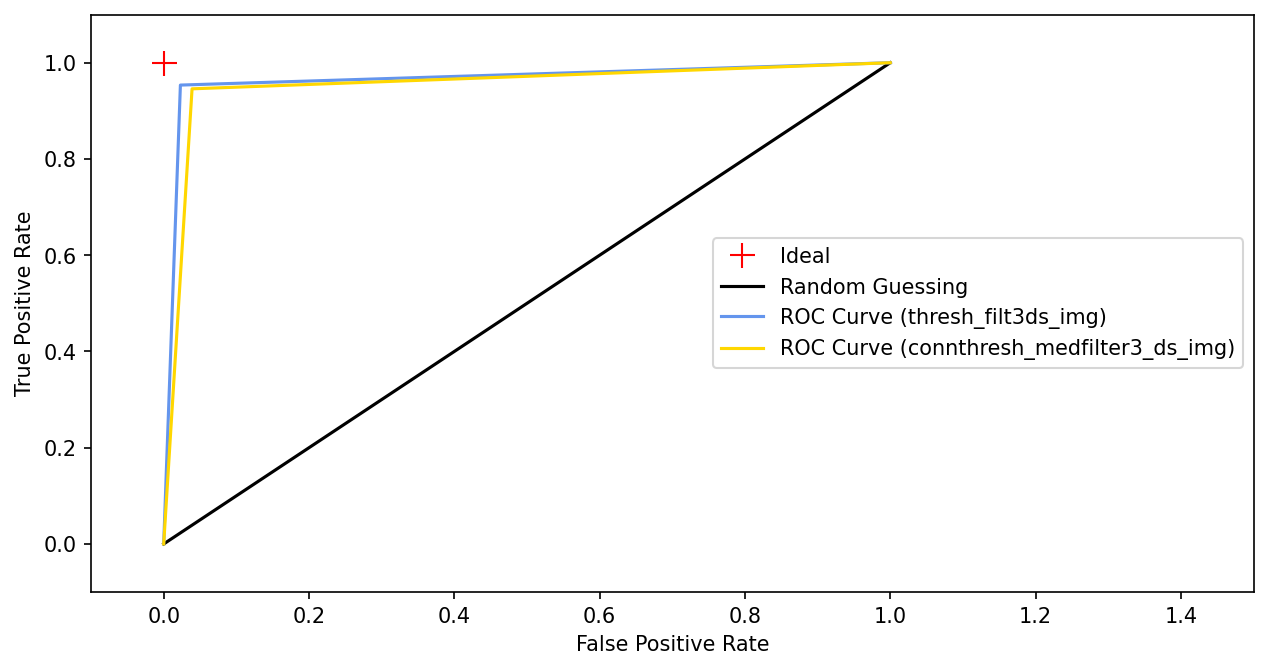

In [19]:
# Not accurate - just to check
fig, ax1 = plt.subplots(1, 1,figsize=(10,5), dpi=150)

ax1.plot(0.0, 1.0, 'r+', markersize=12, label='Ideal')
ax1.plot([0, 1], [0, 1], 'k-', label='Random Guessing')

colors = ['cornflowerblue','gold','mediumseagreen','tomato', 'cyan', 'pink']
for color,c_filt,c_name in zip(colors,[thresh_filt3ds_img, connthresh_medfilter3_ds_img],['thresh_filt3ds_img', 'connthresh_medfilter3_ds_img']):
    fpr, tpr, thresholds = roc_curve(thresh_ds_img.ravel().astype(int), c_filt.ravel())
    ax1.plot(fpr, tpr, '-', markersize=0.01, label='ROC Curve ({})'.format(c_name),color=color)
# Decorations
ax1.set_xlim(-0.1, 1.5); ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate'); ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="center right", fontsize=10);

In [20]:
del img
del thresh_img
del thresh_ds_img
del thresh_filt3ds_img
del threshlow_img
del threshlow_ds_img
del threshlow_filt3ds_img

Largest label = 2
0.9983514401709401


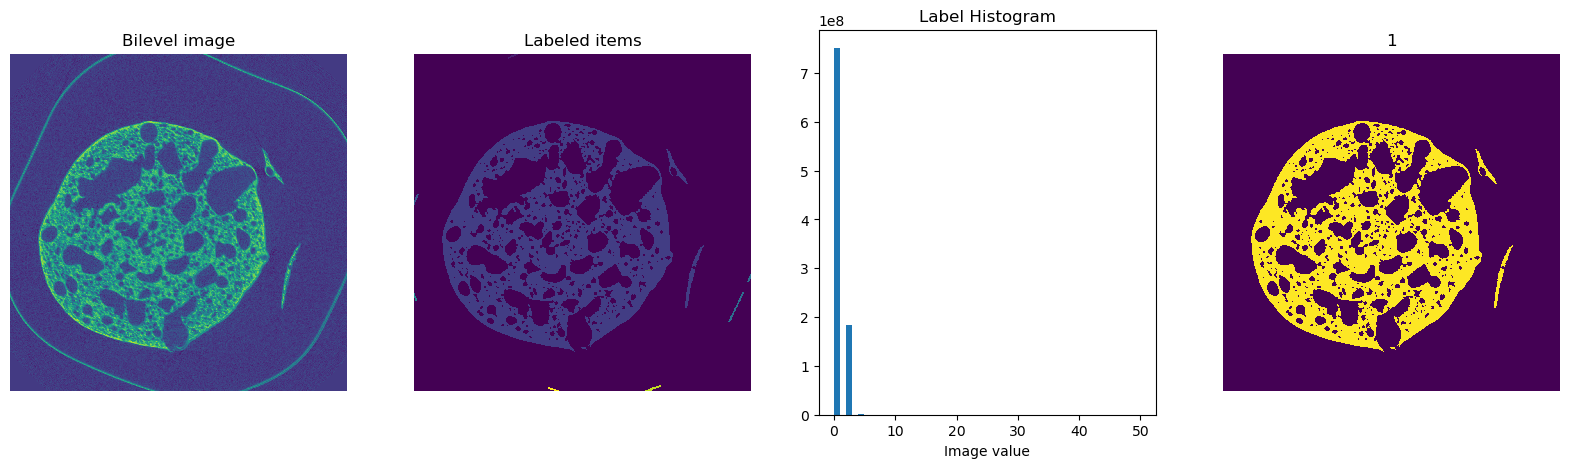

In [21]:
# Start extracting pores - first extract only the bread sample
perform_kmeans_clustering_3d = getattr(segment_kmeans_clust,"perform_kmeans_clustering_3d")
extract_clusters_3d = getattr(segment_kmeans_clust,"extract_clusters_3d")

# Use mostly when there are more than 2 breads in the slices, NOTE: does not work very well when the second bread starts off joined to the first one
# Try GMM analysis (at the end) to optimize
# connthresh_medfilter3_ds_img_1 = segment_kmeans_clust(connthresh_medfilter3_ds_img, n_clusters=2)

# Works nicely for one bread slice
connthresh_medfilter3_ds_img_1 = extract_clusters_3d(connthresh_medfilter3_ds_img, downsample_img, img_sample)

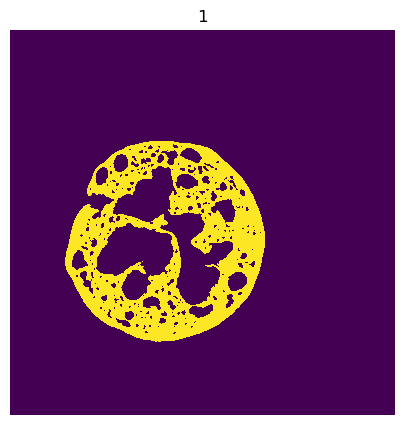

In [22]:
cur_img_sample = img_sample-100

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.imshow(connthresh_medfilter3_ds_img_1[cur_img_sample],interpolation='none'), ax.axis('off')
ax.set_title('1');

In [23]:
# 3D Visualizations

Text(0.5, 1.0, 'Bilevel Image')

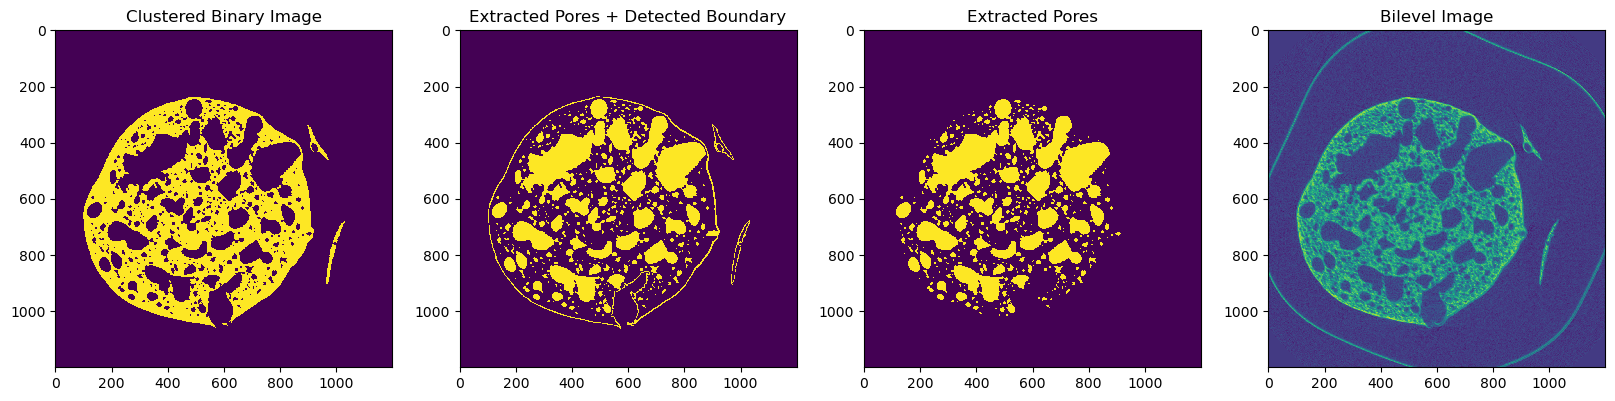

In [24]:
# Begin Pore extraction
extract_pores_3d = getattr(segment_extract_pores,"extract_pores_3d")

inverted_image_1, inv_img_test_1, filled_pores_1 =  extract_pores_3d(connthresh_medfilter3_ds_img_1)

# Visualize Extraction
fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].imshow(connthresh_medfilter3_ds_img_1[img_sample], interpolation='none', cmap='viridis')
ax[0].set_title('Clustered Binary Image')
ax[1].imshow(inv_img_test_1[img_sample], interpolation='none', cmap='viridis')
ax[1].set_title('Extracted Pores + Detected Boundary')
ax[2].imshow(inverted_image_1[img_sample], interpolation='none', cmap='viridis')
ax[2].set_title('Extracted Pores')
ax[3].imshow(downsample_img[img_sample], interpolation='none', cmap='viridis')
ax[3].set_title('Bilevel Image')

In [25]:
del medfilter3_ds_img
del connthresh_medfilter3_ds_img
del inv_img_test_1

In [ ]:
# Can compare both watershed based and connected components labelling based segmentation of the extracted pores

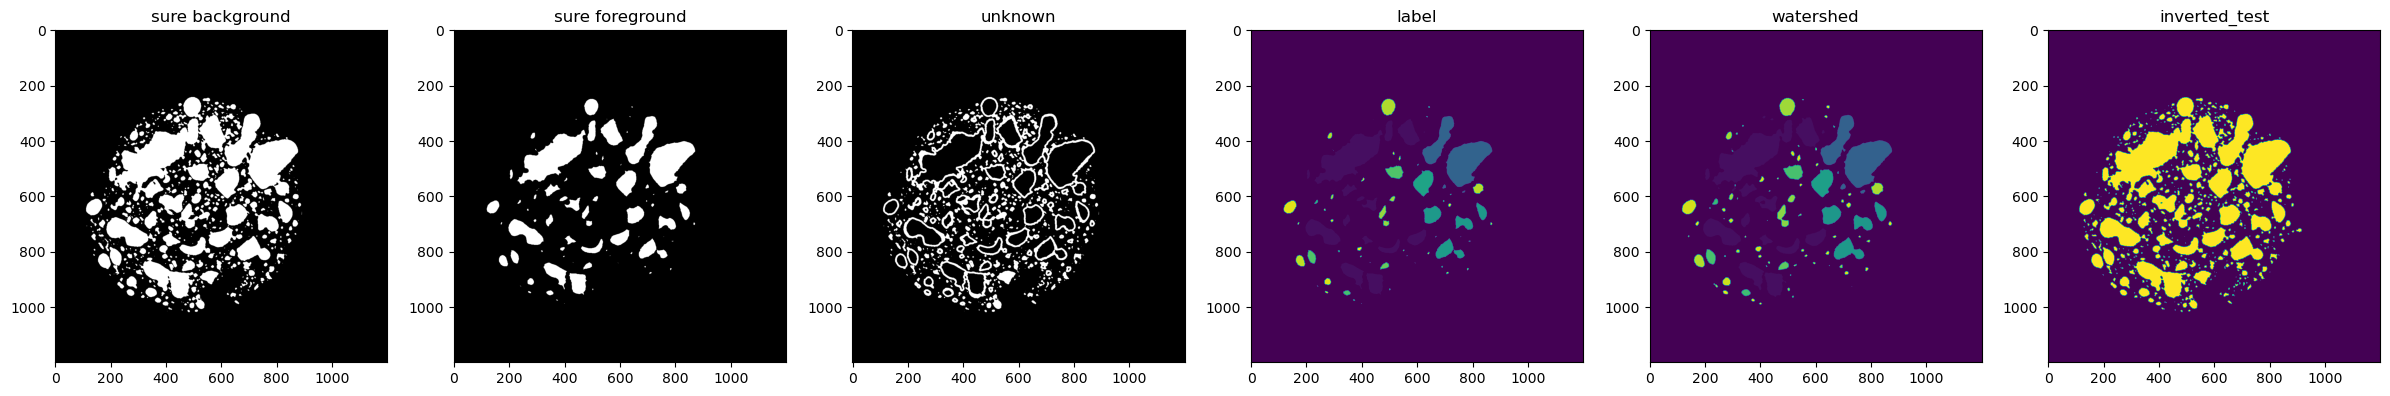

In [26]:
# Segmenting Pores - Processing (Opening, Dilation, extraction of Fg and Bg) + Watershed method
segment_pores_watershed_3d = getattr(segment_extract_pores,"segment_pores_watershed_3d")

watershed_fg_1 = segment_pores_watershed_3d(inverted_image_1, img_sample)

In [27]:
# Labelling by connected components (different method)
segment_pores_lbl_3d = getattr(segment_extract_pores,"segment_pores_lbl_3d")

lbl_1, inverted_image_dist_1 = segment_pores_lbl_3d(inverted_image_1)

Number of components (Watershed) = 4699
Number of components (Label) = 27306


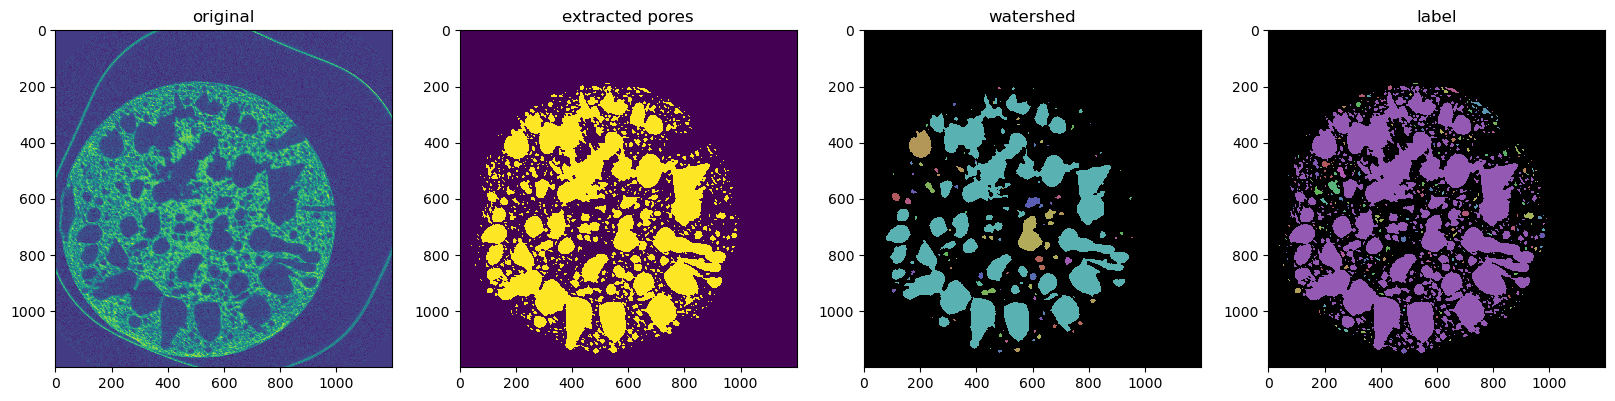

In [28]:
# Visualize label and watershed based methods together using custom cmap
goldenCM = getattr(plots_colormaps_lec,"goldenCM")
randomCM = getattr(plots_colormaps_lec,"randomCM")
cur_img_sample = img_sample+150

fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(downsample_img[cur_img_sample], interpolation='none', cmap='viridis'); ax[0].set_title('original')
ax[1].imshow(inverted_image_1[cur_img_sample], interpolation='none', cmap='viridis'); ax[1].set_title('extracted pores')
ax[2].imshow(watershed_fg_1[cur_img_sample], interpolation='none', cmap=goldenCM(watershed_fg_1.max())); ax[2].set_title('watershed')
ax[3].imshow(lbl_1[cur_img_sample], interpolation='none', cmap=goldenCM(lbl_1.max())); ax[3].set_title('label')
print(f'Number of components (Watershed) = {watershed_fg_1.max()}')
print(f'Number of components (Label) = {lbl_1.max()}')

In [29]:
# Process labelled pores
get_neighbors = getattr(segment_process_segments,"get_neighbors")
merge_regions = getattr(segment_process_segments,"merge_regions")
filter_regions_by_size = getattr(segment_process_segments,"filter_regions_by_size")

size_thresh = 10
distance_thresh = 7

# Currently not performing merge_regions as merge errors were prevalent while prototyping
merged_labelled_image_ws, count_regions_filtered_ws = filter_regions_by_size(watershed_fg_1,size_thresh)
merged_labelled_image_lbl, count_regions_filtered_lbl = filter_regions_by_size(lbl_1,size_thresh)

4588
20276


In [ ]:
# Generally 3-5% pores are size-filtered for watershed segmentation
# Generally 23-27% pores are size-filtered for label segmentation

In [47]:
del watershed_fg_1
del lbl_1

# Still preserving connthresh_medfilter3_ds_img_1, inverted_image_1, filled_pores_1, downsample_img

In [30]:
rough_porosity = getattr(pores_pore_regionprops,"rough_porosity")

rough_porosity(merged_labelled_image_ws, filled_pores_1)
rough_porosity(merged_labelled_image_lbl, filled_pores_1)

Porosity (%) = 23.282049519988753
Porosity (%) = 37.87356530412132


In [31]:
# Regionprops
regions_ws = regionprops(merged_labelled_image_ws)
regions_lbl = regionprops(merged_labelled_image_lbl)

regions_full_1 = regionprops_table(label(filled_pores_1)[0], properties=('centroid', 'area'))
regions_full_1 = pd.DataFrame(regions_full_1)
#regions_full_1 = regionprops(label(filled_pores_1)[0])

In [ ]:
type(filled_pores_1.shape[0])
print(regions_full_1)

In [32]:
pore_volumes_ws = [region.area for region in regions_ws]
pore_volumes_lbl = [region.area for region in regions_lbl]
pore_lengths_ws = [max(region.bbox[3] - region.bbox[0], region.bbox[4] - region.bbox[1], region.bbox[5] - region.bbox[2]) for region in regions_ws]
pore_lengths_lbl = [max(region.bbox[3] - region.bbox[0], region.bbox[4] - region.bbox[1], region.bbox[5] - region.bbox[2]) for region in regions_lbl]

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

# Plot the pore size distribution
ax[0].hist(pore_volumes_ws, bins=151, density=True, range=(100,3000), edgecolor='blue', alpha=0.6, label='Watershed')
ax[0].hist(pore_volumes_lbl, bins=151, density=True, range=(100,3000), edgecolor='orange', alpha=0.3, label='Label')
ax[0].set_xlabel('Pore Volume')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pore Size Distribution')
ax[0].legend(loc='upper right')

# Plot the pore length distribution
ax[1].hist(pore_lengths_ws, bins=101, density=True, range=(0,75), edgecolor='blue', alpha=0.6, label='Watershed')
ax[1].hist(pore_lengths_lbl, bins=101, density=True, range=(0,75), edgecolor='orange', alpha=0.3, label='Label')
ax[1].set_xlabel('Pore Length')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pore Length Distribution')
ax[1].legend(loc='upper right')

In [34]:
# Plot distributions as a function of distance from centroid
# zconstrain assumes that the same x and y coordinates are true centroids for each slice
# NOTE - implement accurate z constrain
compute_distance_from_centroid_zconstrain = getattr(segment_distance_thickness,"compute_distance_from_centroid_zconstrain")
compute_distance_from_centroid = getattr(segment_distance_thickness,"compute_distance_from_centroid")

pore_distances_ws = [compute_distance_from_centroid(regions_full_1, region.centroid, filled_pores_1.shape[0]) for region in regions_ws]
pore_distances_lbl = [compute_distance_from_centroid(regions_full_1, region.centroid, filled_pores_1.shape[0]) for region in regions_lbl]

pore_distances_ws_zconstrain = [compute_distance_from_centroid_zconstrain(regions_full_1, region.centroid) for region in regions_ws]
pore_distances_lbl_zconstrain = [compute_distance_from_centroid_zconstrain(regions_full_1, region.centroid) for region in regions_lbl]

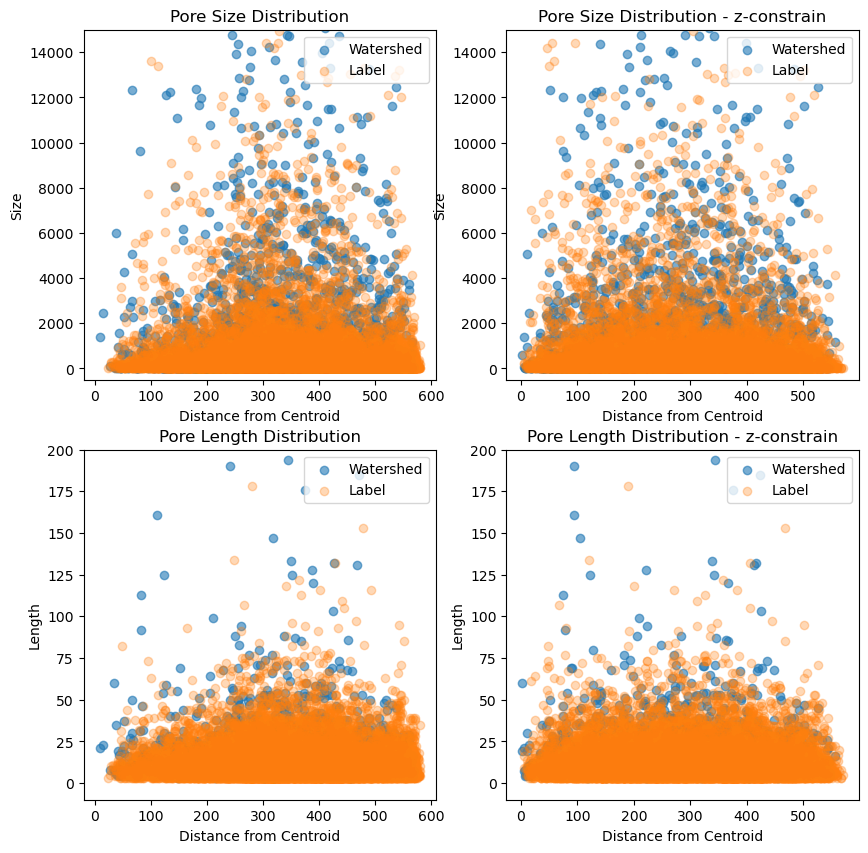

In [35]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

# Plot the pore size distribution
ax[0,0].scatter(pore_distances_ws, pore_volumes_ws, alpha=0.6, label='Watershed')
ax[0,0].scatter(pore_distances_lbl, pore_volumes_lbl, alpha=0.3, label='Label')
ax[0,0].set_xlabel('Distance from Centroid')
ax[0,0].set_ylabel('Size')
ax[0,0].set_ylim(-500,15000)
ax[0,0].set_title('Pore Size Distribution')
ax[0,0].legend(loc='upper right')

ax[0,1].scatter(pore_distances_ws_zconstrain, pore_volumes_ws, alpha=0.6, label='Watershed')
ax[0,1].scatter(pore_distances_lbl_zconstrain, pore_volumes_lbl, alpha=0.3, label='Label')
ax[0,1].set_xlabel('Distance from Centroid')
ax[0,1].set_ylabel('Size')
ax[0,1].set_ylim(-500,15000)
ax[0,1].set_title('Pore Size Distribution - z-constrain')
ax[0,1].legend(loc='upper right')

ax[1,0].scatter(pore_distances_ws, pore_lengths_ws, alpha=0.6, label='Watershed')
ax[1,0].scatter(pore_distances_lbl, pore_lengths_lbl, alpha=0.3, label='Label')
ax[1,0].set_xlabel('Distance from Centroid')
ax[1,0].set_ylabel('Length')
ax[1,0].set_ylim(-10,200)
ax[1,0].set_title('Pore Length Distribution')
ax[1,0].legend(loc='upper right')

ax[1,1].scatter(pore_distances_ws_zconstrain, pore_lengths_ws, alpha=0.6, label='Watershed')
ax[1,1].scatter(pore_distances_lbl_zconstrain, pore_lengths_lbl, alpha=0.3, label='Label')
ax[1,1].set_xlabel('Distance from Centroid')
ax[1,1].set_ylabel('Length')
ax[1,1].set_ylim(-10,200)
ax[1,1].set_title('Pore Length Distribution - z-constrain')
ax[1,1].legend(loc='upper right')

In [ ]:
# Pairplots - sns (compare with results from porespy)

In [90]:
# Helpful functions
montage_pad = getattr(plots_plots_3d,"montage_pad")

In [91]:
# Distance Maps and Visualisation
distance_map_calculation = False # Can calculate it later with porespy

if distance_map_calculation:
    merged_labelled_image_lbl_dist = distance_transform_edt(merged_labelled_image_lbl)
    merged_labelled_image_ws_dist = distance_transform_edt(merged_labelled_image_ws)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    ax1.imshow(montage_pad(merged_labelled_image_ws_dist[::20]), cmap='nipy_spectral')
    ax1.set_title('Distance maps - Axial Slices')
    ax2.imshow(montage_pad(merged_labelled_image_ws_dist.swapaxes(0, 1)[::20]), cmap='nipy_spectral')
    ax2.set_title('Distance maps - Sagittal Slices'); 


In [92]:
# Thickness maps and Visualisation
thickness_map_calculation = False # Can calculate it later with porespy

if thickness_map_calculation:
    thickness_map_3d = getattr(segment_distance_thickness,"thickness_map_3d")
    # Can use local thickness function from porespy
    # Visualisation - similar to distance map above (if using written function)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
    for i, (cax, clabel) in enumerate(zip([ax1, ax2, ax3], ['xy', 'zy', 'zx'])):
        cax.imshow(np.max(thickness_map_3d, i).squeeze(),
                   interpolation='none', cmap='jet')
        cax.set(title='{} Projection'.format(clabel), xlabel=clabel[0], ylabel=clabel[1]);

  0%|          | 0/25 [00:00<?, ?it/s]

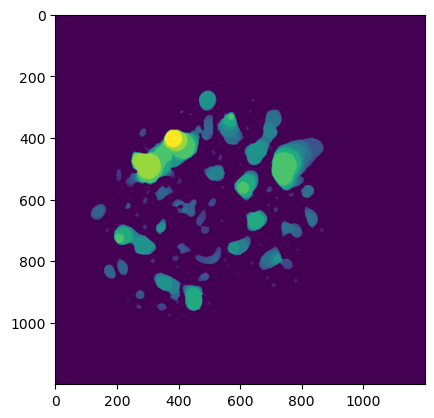

In [36]:
# Porespy - begin
# Snow segmentation oversegments heavily
lt_ws = ps.filters.local_thickness(merged_labelled_image_ws)
plt.imshow(lt_ws[img_sample])

In [37]:
psd_ws = ps.metrics.pore_size_distribution(lt_ws, bins=51, log=True)
plt.bar(psd_ws.LogR, psd_ws.satn, width=psd_ws.bin_widths, edgecolor='k')
print(ps.metrics.porosity(merged_labelled_image_ws))

6.364629660948015e-07


In [38]:
regions_ps_ws = ps.metrics.regionprops_3D(merged_labelled_image_ws)

pore_volume_ps_ws = [region.volume for region in regions_ps_ws]
pore_surface_area_ps_ws = [region.surface_area for region in regions_ps_ws]
pore_sphericity_ws = [region.sphericity for region in regions_ps_ws]
#pore_convex_volume_ps_ws = [region.convex_volume for region in regions_ps_ws]

In [39]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

# Plot the pore size distribution
ax[0].hist(pore_volume_ps_ws, bins=151, density=True, range=(50,1000), edgecolor='blue', alpha=0.6)
#ax[0].hist(pore_volume_ps_14, bins=151, density=True, range=(50,1000), edgecolor='orange', alpha=0.4)
ax[0].set_xlabel('Pore Volume')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pore Volume Distribution')

# Plot the pore size distribution
ax[1].hist(pore_surface_area_ps_ws, bins=151, density=True, range=(50,5000), edgecolor='blue', alpha=0.6)
#ax[1].hist(pore_surface_area_ps_14, bins=151, density=True, range=(50,5000), edgecolor='orange', alpha=0.4)
ax[1].set_xlabel('Pore SA')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pore Surface Area Distribution')

Text(0.5, 1.0, 'Pore Surface Area Distribution')

In [92]:
# Plot other metrics of porespy

In [ ]:
print(regions_ws[336].area, regions_ps_ws[336].volume)
len(pore_distances_ws_zconstrain)

In [40]:
# Pairplot (also compare to previous)
# Construct dataframe
df_pair_pore = pd.DataFrame(
    {'label' : [region.label for region in regions_ps_ws],
     'centroid-0' : [region.centroid[0] for region in regions_ps_ws],
     'centroid-1' : [region.centroid[1] for region in regions_ps_ws],
     'centroid-2' : [region.centroid[2] for region in regions_ps_ws],
     'volume_ps' : pore_volume_ps_ws,
     'surface_area' : pore_surface_area_ps_ws,
     'sphericity' : pore_sphericity_ws,
     'length' : pore_lengths_ws,
     'distance_centroid' : pore_distances_ws,
     'distance_centroid_zconstraint' : pore_distances_ws_zconstrain
    })

In [41]:
# Ro1a = 1, Ru1a = 2, V1a = 3, W1a = 4
if bread_type == 'Ro1a':
    bread_label_i = 1
elif bread_type == 'Ru1a':
    bread_label_i = 2
elif bread_type == 'V1a':
    bread_label_i = 3
elif bread_type == 'W1a':
    bread_label_i = 4
else:
    print('Check Bread Type')

df_pair_pore['bread_label'] = [bread_label_i for region in regions_ws]
df_pair_pore.sample(5)

label  centroid-0   centroid-1  centroid-2  volume_ps  surface_area  \
3020   3021  498.475000  1018.112500  488.650000         80    204.751617   
266     267  126.039604   758.940594  455.930693        101    180.178848   
606     607  228.500000   617.437768  785.461373        466    446.476501   
1573   1574  364.166667   643.055556  136.685185         54     76.714027   
360     361  168.114872   630.132127  612.345532      11996   4192.595215   

      length  distance_centroid  distance_centroid_zconstraint  bread_label  
3020      10         453.729600                     419.257647            3  
266        7         260.792342                     168.604289            3  
606       12         291.916345                     275.504814            3  
1573       7         378.430067                     376.397779            3  
360       45         189.522854                     106.329529            3

In [42]:
sorted_df = df_pair_pore.sort_values(by='volume_ps', ascending=False)
sorted_df.head(10)

label  centroid-0   centroid-1  centroid-2  volume_ps  surface_area  \
38       39  397.780575   652.185076  485.479531   51146023  4.693276e+06   
331     332  277.917971   480.400288  722.564336    1753454  1.609725e+05   
558     559  334.710996   647.065569  749.139360    1645128  1.900784e+05   
567     568  293.420912   812.147121  690.336725    1119177  1.297728e+05   
1575   1576  467.251856   738.489901  625.328138    1109672  1.543896e+05   
1265   1266  451.700472   685.384855  486.000811     699129  1.214234e+05   
2984   2985  534.308872  1022.027552  532.453780     587353  6.091094e+04   
597     598  266.229622   574.873600  601.486014     564270  4.042201e+04   
2982   2983  546.014159   977.538671  677.034944     493125  3.767298e+04   
1335   1336  351.485207   463.741111  826.644475     465678  3.776998e+04   

      length  distance_centroid  distance_centroid_zconstraint  bread_label  
38       966          93.320680                      58.410077            3  
331      302         247.660841                     243.144349            3  
558      354         243.496557                     243.302836            3  
567      451         280.306664                     278.522148            3  
1575     290         229.671593                     180.314864            3  
1265     322         155.061997                      89.393588            3  
2984     185         472.103147                     423.168025            3  
597      161         111.026711                      94.196461            3  
2982     131         468.544865                     413.142871            3  
1335     194         345.007876                     343.989780            3

In [45]:
# Sampling dataframe for pairplot to preserve time
df_pairplot_pore = sns.pairplot(df_pair_pore.sample(2500),vars=['label', 'centroid-0', 'centroid-1', 'centroid-2', 'volume_ps', 'surface_area', 'sphericity', 'distance_centroid', 'distance_centroid_zconstraint']);

df_pairplot_pore.axes[0,4].set_xlim((0,1e5))
df_pairplot_pore.axes[0,5].set_xlim((0,1e4))
df_pairplot_pore.axes[0,6].set_xlim((0,400))

df_pairplot_pore.axes[4,0].set_ylim((0,1e5))
df_pairplot_pore.axes[5,0].set_ylim((0,1e4))
df_pairplot_pore.axes[6,0].set_ylim((0,400))

plt.subplots_adjust(top=(0.95))
plt.suptitle('Pairplot for Bread '+bread_type+' | Slices='+str(start_idx)+':'+str(end_idx), fontsize=20)
plt.savefig(os.path.join(output_path, (bread_type+'_sampled_pairplot_'+str(start_idx)+'to'+str(end_idx)+'.png')))

In [ ]:
# Using 128GB RAM (1 core) - Time (approximately) - 35 + 25 = 1 hour for 256 slices
# Using 128GB RAM (1 core) - Time (approximately) - 1:15 + 40 = 1:55 hour for 600 slices

In [ ]:
# Save images and data
# connthresh_medfilter3_ds_img_1 (image - bin), filled_pores_1 (image - bin)
# merged_labelled_image_lbl (image - seg), merged_labelled_image_ws (image - seg)
# lt_ws (thickness map - image), df_pair_pore (DataFrame)
#img = read_images('/cluster/scratch/spruthi/qbi2024_project/V1a/V1a_0{0:04}.tif', 545, 800)

In [46]:
# Saving
save_TIFF(os.path.join(output_path, (bread_type+'_connthresh_medfilter3_ds_img_1_{0:04}.tif')), connthresh_medfilter3_ds_img_1, start_idx)
save_TIFF(os.path.join(output_path, (bread_type+'_filled_pores_1_{0:04}.tif')), filled_pores_1, start_idx)
save_TIFF(os.path.join(output_path, (bread_type+'_merged_labelled_image_lbl_{0:04}.tif')), merged_labelled_image_lbl, start_idx)
save_TIFF(os.path.join(output_path, (bread_type+'_merged_labelled_image_ws_{0:04}.tif')), merged_labelled_image_ws, start_idx)
save_TIFF(os.path.join(output_path, (bread_type+'_lt_ws_{0:04}.tif')), lt_ws, start_idx)

df_pair_pore.to_pickle(os.path.join(output_path, (bread_type+'_df_pair_pore.pkl')))
df_pair_pore.to_csv(os.path.join(output_path, (bread_type+'_df_pair_pore.csv')))

  0%|          | 0/650 [00:00<?, ?it/s]

/cluster/home/spruthi/miniconda3/envs/qbi2024/lib/python3.9/site-packages/tifffile/tifffile.py:1436: UserWarning: TiffWriter: ignoring 'shape' argument
  warnings.warn(


  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

In [ ]:
test = read_images('/cluster/scratch/spruthi/qbi2024_project/V1a_save_256/V1a_connthresh_medfilter3_ds_img_1_{0:04}.tif', 545, 800)
plt.imshow(test[img_sample], cmap='viridis')

In [ ]:
test_df = pd.read_pickle(os.path.join(output_path, 'V1a_df_pair_pore.pkl'))
test_df.sample(5)

In [ ]:
# Multiply by voxel size
# Radial_density_distribution
# Regions_to_network

# Normalisation and clustering
# Sphericity
# KS test and Wilcox ranked signed test/T-test - Bonferonni correction
# GMM

In [99]:
# Network connectivity
pore_network_manual = False

if pore_network_manual:
    analyze_pore_network_connectivity = getattr(pores_pore_network, "analyze_pore_network_connectivity")
    num_cc, graph_img = analyze_pore_network_connectivity(merged_labelled_image_ws>0)

In [100]:
# Compare to other bread types

In [101]:
# Statistical Comparison